In [1]:
import os
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm  
import cv2
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



In [2]:
transform = transforms.Compose([
    transforms.Resize((60, 80)),
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file, header=None)
        self.root_dir = root_dir
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.labels_df[1] = self.label_encoder.fit_transform(self.labels_df[1])

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels_df.iloc[idx, 0])
        image = Image.open(img_name)
        label = torch.tensor(self.labels_df.iloc[idx, 1], dtype=torch.long)  # Convert label to tensor

        if self.transform:
            image = self.transform(image)

        return image, label

# Create custom dataset
dataset = CustomDataset(csv_file='/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/data/labels.txt', root_dir='/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/data/images', transform=transform)

# Load the trained model for prediction
model = torchvision.models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.label_encoder.classes_))
model.load_state_dict(torch.load( '/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/models/torch.pth'))
model.eval()


In [ ]:
def extract_colors(image_path, num_colors=5):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert image to grayscale for contour detection
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Instead of binary threshold, use adaptive thresholding
    adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                            cv2.THRESH_BINARY_INV, 11, 2)

    # Find contours from the adaptive threshold image
    contours, hierarchy = cv2.findContours(adaptive_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the largest contour
    mask = np.zeros_like(gray)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        cv2.drawContours(mask, [largest_contour], -1, color=255, thickness=-1)

    # Apply the mask to the original image
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    # Flatten the image to a 2D array of pixels
    # Consider all pixels for color clustering to include white and other light colors
    pixels = image.reshape(-1, 3)

    # Apply K-means clustering to find dominant colors
    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_

    return colors.astype(int), masked_image


#COVERT RGB TO HEX
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(rgb[0], rgb[1], rgb[2])


#DISPLAY COLOURS IN BOX AND COLOUR CODES
def display_colors(colors):
    # Create a square image with the extracted colors
    color_img = np.zeros((100, len(colors)*100, 3), dtype=np.uint8)
    for i, color in enumerate(colors):
        color_img[:, i*100:(i+1)*100] = color
        # Convert RGB to hex and print
        hex_color = rgb_to_hex(color)
        print(f"Color {i+1}: {hex_color}")
     
    print("\n")
    # Display the image using matplotlib
    plt.imshow(color_img)
    plt.axis('off')
    plt.show()

In [3]:
rgb_shades_df = pd.read_csv('/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/data/colours_rgb_shades_clean.csv')

In [4]:
def find_closest_hex_color(extracted_hex_colors, color_df):
    closest_colors = []
    for hex_color in extracted_hex_colors:
        hex_color = hex_color.lstrip('#')  # Ensure we're working with the HEX part only

        # Calculate the distance to each color in the dataframe
        distances = color_df['RGB Hex'].apply(
            lambda x: sum((int(x[i:i+2], 16) - int(hex_color[i:i+2], 16)) ** 2 for i in (0, 2, 4))
            if len(x) == 6 else float('inf')
        )

        # Get the index of the closest color
        closest_index = distances.idxmin()
        closest_color = color_df.iloc[closest_index]
        closest_colors.append((closest_color['Color Name'], closest_color['RGB Hex']))

    return closest_colors


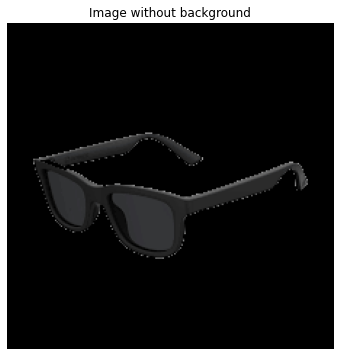



Color 1: #f6f7f9
Color 2: #303032
Color 3: #616161
Color 4: #171717
Color 5: #acacac




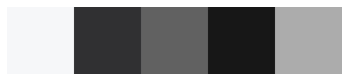



Closest color names and HEX values:
White: #F7F7F7
grey19: #303030
grey38: #616161
black: #171717
grey67: #ABABAB




In [6]:
# Example usage
query_image_path = "/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/data/glass.png"  # Full path to the image file
colors, masked_image = extract_colors(query_image_path)

#DIPLAY IMAGE WITHOUT Background
plt.figure(figsize=(6, 6))
plt.imshow(masked_image)
plt.title("Image without background")
plt.axis('off')
plt.show()

# Convert extracted colors to HEX format
extracted_hex_colors = [rgb_to_hex(color) for color in colors]

print("\n")
# Optionally, display the extracted colors
display_colors(colors)
print("\n")

# Find and display the closest colors along with their names
closest_colors_info = find_closest_hex_color(extracted_hex_colors, rgb_shades_df)
print("Closest color names and HEX values:")
for color_name, hex_color in closest_colors_info:
    print(f"{color_name}: #{hex_color}")
print("\n")    

